## Use Case : tweets NLP - Part 2
This notebook addresses the use case of analyzing tweets related to **Inwi** and the **Moroccan telecommunications sector**.

This is the **second notebook** of this use case (**tweets-NLP.ipynb**) that applies NLP on the tweets for sentiment analysis.

### Objectives:
- Ingest fresh tweets their metadata using Selenium for web scraping.
- Extract 10 tweets discussing Inwi and 10 tweets discussing the Moroccan telco sector.
- Store the tweets and their metadata in a SQlite database.
- Analyze the sentiment of tweets and score them from 0 (negative) to 1 (positive).
- Investigate common topics in negative tweets.

In [2]:
!pip install seaborn vaderSentiment transformers matplotlib langchain


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: C:\Users\Zahra\Desktop\JupyterProjects\venv\Scripts\python.exe -m pip install --upgrade pip


#### Imports

In [131]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

plt.style.use('ggplot')

### Connect to SQLite database and load tweets

In [132]:
# Connect to the SQLite database
conn = sqlite3.connect("tweetsDB.db")

# Fetch data into a pandas DataFrame
query = "SELECT id, tweet_text, tweet_date, nbr_characters, nbr_retweets, nbr_likes, author FROM tweets"
df = pd.read_sql_query(query, conn)

# Display the first few rows
print("Total tweets:", len(df))
print(df.head())

Total tweets: 20
   id                                         tweet_text           tweet_date  \
0   1   Après la LNFP, c'est au la Botola Pro INWI qu...  2024-11-09 22:07:54   
1   2     Official Botola Pro Inwi page will follow soon  2024-11-09 21:38:11   
2   3  Je pense très sincèrement que l’absurdité est ...  2024-11-09 10:59:35   
3   4         Botola Inwi Pro is corrupted \n@fifacom_fr  2024-11-09 21:50:20   
4   5  Programme de la 5eme journée du championnat du...  2024-11-16 08:35:29   

   nbr_characters  nbr_retweets  nbr_likes                  author  
0             115             0          8              BotolaNews  
1              46             3         30  𝗠𝗩𝗡_𝗘𝗡 | 𝗙𝗼𝗼𝘁𝗯𝗮𝗹𝗹 𝗡𝗲𝘄𝘀  
2             224             1          2       from 04 with love  
3              41             0          2                  🅜🅞🅝🅒🅔🅕  
4             189             0          4                  Saad M  


In [133]:
df.shape

(20, 7)

In [134]:
df.head()

,id,tweet_text,tweet_date,nbr_characters,nbr_retweets,nbr_likes,author
0,1,"Après la LNFP, c'est au la Botola Pro INWI qu...",2024-11-09 22:07:54,115,0,8,BotolaNews
1,2,Official Botola Pro Inwi page will follow soon,2024-11-09 21:38:11,46,3,30,𝗠𝗩𝗡_𝗘𝗡 | 𝗙𝗼𝗼𝘁𝗯𝗮𝗹𝗹 𝗡𝗲𝘄𝘀
2,3,Je pense très sincèrement que l’absurdité est ...,2024-11-09 10:59:35,224,1,2,from 04 with love
3,4,Botola Inwi Pro is corrupted \n@fifacom_fr,2024-11-09 21:50:20,41,0,2,🅜🅞🅝🅒🅔🅕
4,5,Programme de la 5eme journée du championnat du...,2024-11-16 08:35:29,189,0,4,Saad M


#### EDA

<Axes: title={'center': 'Retweets Distribution'}>

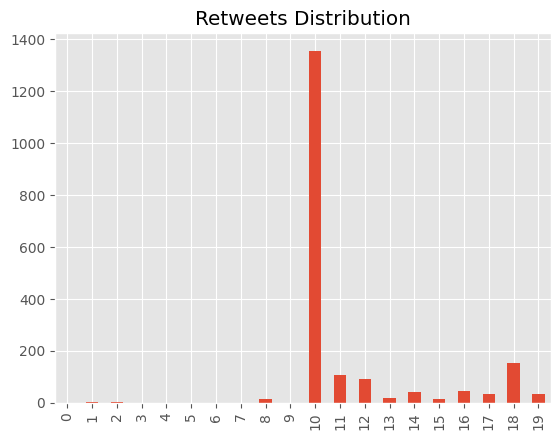

In [135]:
df['nbr_retweets'].plot(kind='bar', title='Retweets Distribution')

<Axes: title={'center': 'Likes Distribution'}>

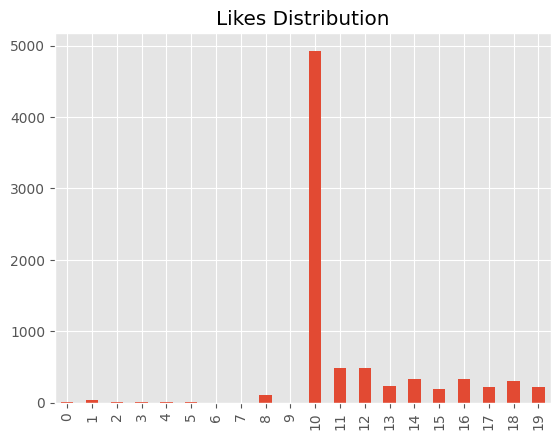

In [136]:
df['nbr_likes'].plot(kind='bar', title='Likes Distribution')

In [147]:
example=df['tweet_text'][0]
print(example)

 Après la LNFP, c'est au la Botola Pro INWI qui aura très prochainement un compte officiel sur les réseaux sociaux.


## Method 1: NLP using VADER (Valence Aware Dictionary and sEntiment Reasoner)

#### convert a VADER compound sentiment score from its original range of -1 to 1 to a new range of 0 to 1

Normalized Score Formula:
$$
\text{Normalized Score} = \frac{\text{Compound Score} + 1}{2}
$$


In [150]:
def normalize_score(compound_score):
    """Convert VADER compound score (-1 to 1) to 0 to 1 scale"""
    return (compound_score + 1) / 2

#### initialize an instance of the **SentimentIntensityAnalyzer** class from the vaderSentiment library.
It is a pretrained sentiment analysis tool provided by the vaderSentiment library. 

It specializes in analyzing the sentiment polarity (positive, negative, or neutral) of text, especially for short and informal texts like tweets, reviews, and comments.

In [152]:
analyzer = SentimentIntensityAnalyzer()

#### Analyze sentiment for each tweet

In [157]:
vader_scores = []                 #empty list to store the normalized sentiment scores for each tweet.
for tweet in df['tweet_text']:
    scores = analyzer.polarity_scores(tweet)      
    normalized_score = normalize_score(scores['compound'])
    vader_scores.append(normalized_score)

In [164]:
# add a column to the dataframe containing the sentiment scores
df['sentiment_score'] = vader_scores

In [165]:
print("\nVADER Sentiment Analysis Results:")
print(df[['tweet_text', 'sentiment_score']])


VADER Sentiment Analysis Results:
                                           tweet_text  sentiment_score
0    Après la LNFP, c'est au la Botola Pro INWI qu...          0.50000
1      Official Botola Pro Inwi page will follow soon          0.50000
2   Je pense très sincèrement que l’absurdité est ...          0.50000
3          Botola Inwi Pro is corrupted \n@fifacom_fr          0.50000
4   Programme de la 5eme journée du championnat du...          0.50000
5   Tous les buts de la 10ème journée de Botola Pr...          0.50000
6                                        INWI \nMAROC          0.50000
7                    Un arbitre de la botola pro inwi          0.50000
8   A l'aeroport a casa quand la meuf d'inwi elle ...          0.50000
9            PUTANGINA NIYOWO INWI WENDY!!!/₱:₱8:₱:₱:          0.50000
10  Pour ceux qui ne realisent pas ce qui est en t...          0.50000
11  Le Maroc  lance sa marque MoroccoTech pour con...          0.50000
12  | La stratégie "Maroc digital 2030" se

#### categorize the tweets into positive or negative based on sentiment score

In [166]:
df["sentiment"] = df["sentiment_score"].apply(lambda x: "POSITIVE" if x > 0.5 else "NEGATIVE")

In [173]:
df.head()

,id,tweet_text,tweet_date,nbr_characters,nbr_retweets,nbr_likes,author,sentiment_score,sentiment
0,1,"Après la LNFP, c'est au la Botola Pro INWI qu...",2024-11-09 22:07:54,115,0,8,BotolaNews,0.5,NEGATIVE
1,2,Official Botola Pro Inwi page will follow soon,2024-11-09 21:38:11,46,3,30,𝗠𝗩𝗡_𝗘𝗡 | 𝗙𝗼𝗼𝘁𝗯𝗮𝗹𝗹 𝗡𝗲𝘄𝘀,0.5,NEGATIVE
2,3,Je pense très sincèrement que l’absurdité est ...,2024-11-09 10:59:35,224,1,2,from 04 with love,0.5,NEGATIVE
3,4,Botola Inwi Pro is corrupted \n@fifacom_fr,2024-11-09 21:50:20,41,0,2,🅜🅞🅝🅒🅔🅕,0.5,NEGATIVE
4,5,Programme de la 5eme journée du championnat du...,2024-11-16 08:35:29,189,0,4,Saad M,0.5,NEGATIVE


#### 1. Sentiment Distribution

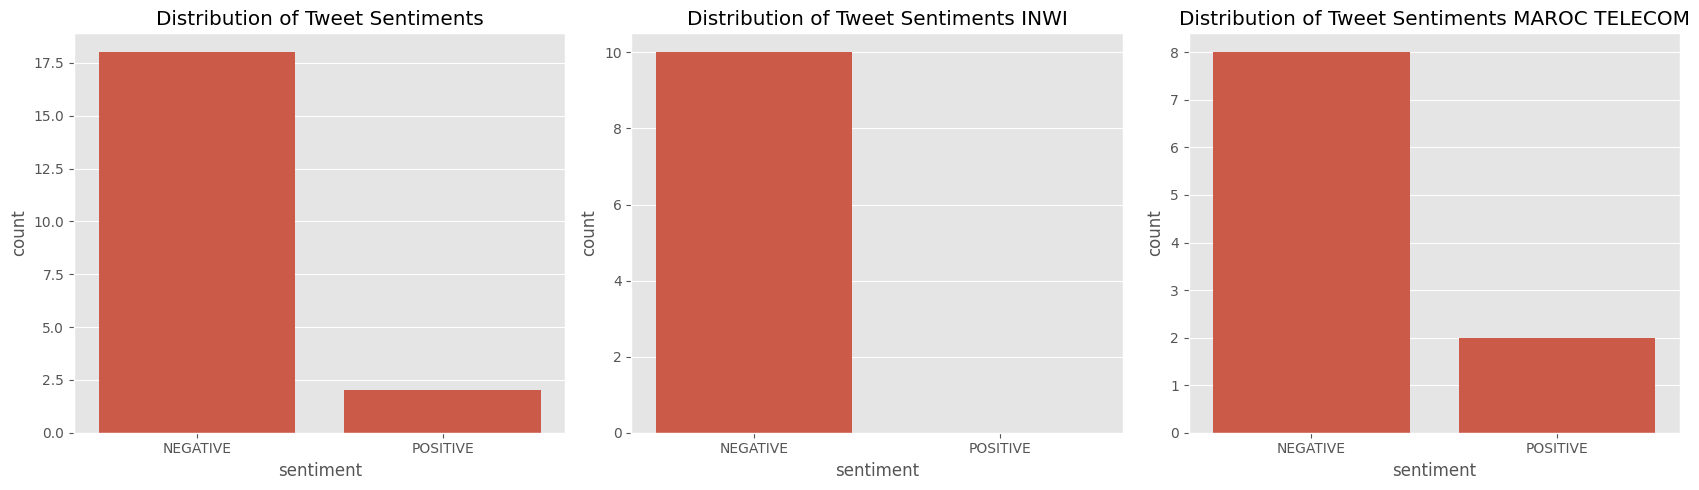

In [179]:
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='sentiment', order=['NEGATIVE', 'POSITIVE'])
plt.title('Distribution of Tweet Sentiments')

plt.subplot(1, 3, 2)
sns.countplot(data=df[0:10], x='sentiment', order=['NEGATIVE', 'POSITIVE'])
plt.title('Distribution of Tweet Sentiments INWI')

plt.subplot(1, 3, 3)
sns.countplot(data=df[10:20], x='sentiment', order=['NEGATIVE', 'POSITIVE'])
plt.title('Distribution of Tweet Sentiments MAROC TELECOM')

plt.tight_layout()
plt.show()

#### 2. Engagement vs Sentiment

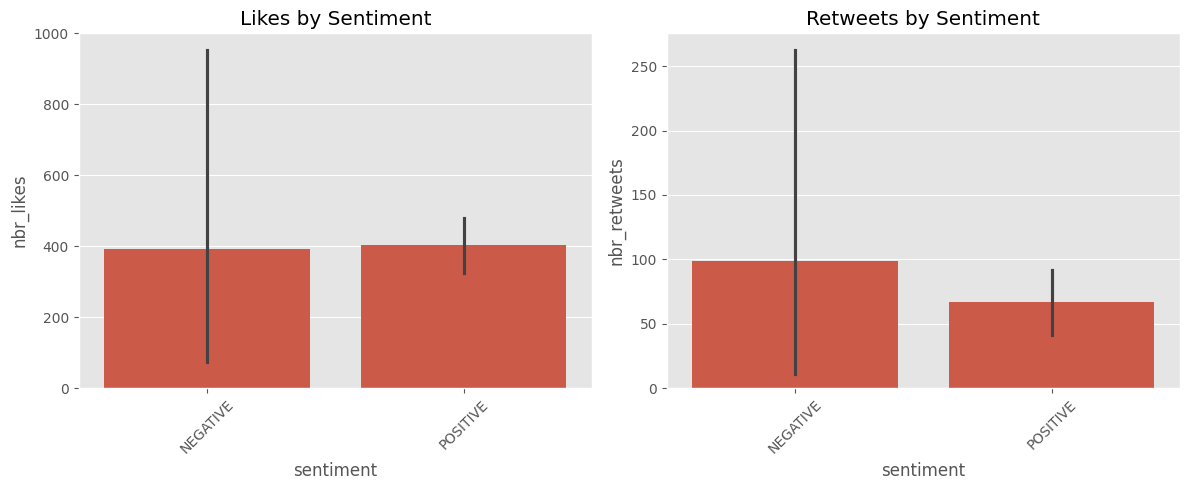

In [180]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=df, x='sentiment', y='nbr_likes')
plt.title('Likes by Sentiment')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=df, x='sentiment', y='nbr_retweets')
plt.title('Retweets by Sentiment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [182]:
# Identify negative tweets (scores <= 0.5)
negative_tweets_vader = df[df['sentiment_score'] <= 0.5]
print("\nNegative Tweets Analysis (VADER):")
print(f"Number of negative tweets: {len(negative_tweets_vader)}")
print("\nSample negative tweets:")
print(negative_tweets_vader[['tweet_text', 'sentiment_score']].head())


Negative Tweets Analysis (VADER):
Number of negative tweets: 18

Sample negative tweets:
                                          tweet_text  sentiment_score
0   Après la LNFP, c'est au la Botola Pro INWI qu...              0.5
1     Official Botola Pro Inwi page will follow soon              0.5
2  Je pense très sincèrement que l’absurdité est ...              0.5
3         Botola Inwi Pro is corrupted \n@fifacom_fr              0.5
4  Programme de la 5eme journée du championnat du...              0.5


## Method 2: LangChain with RoBERTa

In [44]:
# Initialize RoBERTa sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment"
)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [48]:
# Create HuggingFacePipeline
hf_pipeline = HuggingFacePipeline(pipeline=sentiment_pipeline)

# Create LangChain prompt template
prompt = PromptTemplate(
    input_variables=["tweet_text"],
    template="Analyze the sentiment of this tweet: {tweet_text}"
)
# Create LangChain chain
chain = LLMChain(llm=hf_pipeline, prompt=prompt)

In [185]:
# Function to convert RoBERTa output to 0-1 scale
def roberta_to_score(label):
    if label == 'LABEL_0':  # Negative
        return 0.0
    elif label == 'LABEL_1':  # Negative
        return 0.5
    else:  # Positive
        return 1.0

In [187]:
# Analyze sentiment using LangChain
roberta_scores = []
for tweet in df['tweet_text']:
    if pd.isna(tweet):
        roberta_scores.append(None)
        continue
    try:
        result = sentiment_pipeline(tweet)[0]
        score = roberta_to_score(result['label'])
        roberta_scores.append(score)
    except:
        roberta_scores.append(None)

df['roberta_sentiment'] = roberta_scores
print("\nRoBERTa Sentiment Analysis Results:")
print(df[['tweet_text', 'roberta_sentiment']])


RoBERTa Sentiment Analysis Results:
                                           tweet_text  roberta_sentiment
0    Après la LNFP, c'est au la Botola Pro INWI qu...                0.5
1      Official Botola Pro Inwi page will follow soon                0.5
2   Je pense très sincèrement que l’absurdité est ...                0.5
3          Botola Inwi Pro is corrupted \n@fifacom_fr                0.0
4   Programme de la 5eme journée du championnat du...                0.5
5   Tous les buts de la 10ème journée de Botola Pr...                0.5
6                                        INWI \nMAROC                0.5
7                    Un arbitre de la botola pro inwi                0.5
8   A l'aeroport a casa quand la meuf d'inwi elle ...                0.5
9            PUTANGINA NIYOWO INWI WENDY!!!/₱:₱8:₱:₱:                0.5
10  Pour ceux qui ne realisent pas ce qui est en t...                0.5
11  Le Maroc  lance sa marque MoroccoTech pour con...                0.5
12  | La strat

In [193]:
df["sentiment2"] = df["roberta_sentiment"].apply(lambda x: "POSITIVE" if x > 0.5 else "NEGATIVE")

In [231]:
print("\nRoBERTa Sentiment Analysis Results:")
print(df[['tweet_text', 'roberta_sentiment']].head())

# Identify negative tweets (scores <= 0.5)
negative_tweets_roberta = df[df['roberta_sentiment'] <= 0.5]
print("\nNegative Tweets Analysis (RoBERTa):")
print(f"Number of negative tweets: {len(negative_tweets_roberta)}")


RoBERTa Sentiment Analysis Results:
                                          tweet_text  roberta_sentiment
0   Après la LNFP, c'est au la Botola Pro INWI qu...                0.5
1     Official Botola Pro Inwi page will follow soon                0.5
2  Je pense très sincèrement que l’absurdité est ...                0.5
3         Botola Inwi Pro is corrupted \n@fifacom_fr                0.0
4  Programme de la 5eme journée du championnat du...                0.5

Negative Tweets Analysis (RoBERTa):
Number of negative tweets: 19


In [232]:
print(negative_tweets_roberta[['tweet_text', 'roberta_sentiment']])

                                           tweet_text  roberta_sentiment
0    Après la LNFP, c'est au la Botola Pro INWI qu...                0.5
1      Official Botola Pro Inwi page will follow soon                0.5
2   Je pense très sincèrement que l’absurdité est ...                0.5
3          Botola Inwi Pro is corrupted \n@fifacom_fr                0.0
4   Programme de la 5eme journée du championnat du...                0.5
5   Tous les buts de la 10ème journée de Botola Pr...                0.5
6                                        INWI \nMAROC                0.5
7                    Un arbitre de la botola pro inwi                0.5
8   A l'aeroport a casa quand la meuf d'inwi elle ...                0.5
9            PUTANGINA NIYOWO INWI WENDY!!!/₱:₱8:₱:₱:                0.5
10  Pour ceux qui ne realisent pas ce qui est en t...                0.5
11  Le Maroc  lance sa marque MoroccoTech pour con...                0.5
12  | La stratégie "Maroc digital 2030" sera bient.

In [233]:
df

,id,tweet_text,tweet_date,nbr_characters,nbr_retweets,nbr_likes,author,sentiment_score,sentiment,roberta_sentiment,sentiment2
0,1,"Après la LNFP, c'est au la Botola Pro INWI qu...",2024-11-09 22:07:54,115,0,8,BotolaNews,0.50000,NEGATIVE,0.5,NEGATIVE
1,2,Official Botola Pro Inwi page will follow soon,2024-11-09 21:38:11,46,3,30,𝗠𝗩𝗡_𝗘𝗡 | 𝗙𝗼𝗼𝘁𝗯𝗮𝗹𝗹 𝗡𝗲𝘄𝘀,0.50000,NEGATIVE,0.5,NEGATIVE
2,3,Je pense très sincèrement que l’absurdité est ...,2024-11-09 10:59:35,224,1,2,from 04 with love,0.50000,NEGATIVE,0.5,NEGATIVE
3,4,Botola Inwi Pro is corrupted \n@fifacom_fr,2024-11-09 21:50:20,41,0,2,🅜🅞🅝🅒🅔🅕,0.50000,NEGATIVE,0.0,NEGATIVE
4,5,Programme de la 5eme journée du championnat du...,2024-11-16 08:35:29,189,0,4,Saad M,0.50000,NEGATIVE,0.5,NEGATIVE
5,6,Tous les buts de la 10ème journée de Botola Pr...,2024-11-10 19:25:57,54,0,6,BotolaNews,0.50000,NEGATIVE,0.5,NEGATIVE
6,7,INWI \nMAROC,2024-11-16 20:08:43,11,0,0,Zaque bébé influenceur,0.50000,NEGATIVE,0.5,NEGATIVE
7,8,Un arbitre de la botola pro inwi,2024-11-16 22:38:53,32,0,0,Fc Recul,0.50000,NEGATIVE,0.5,NEGATIVE
8,9,A l'aeroport a casa quand la meuf d'inwi elle ...,2024-11-13 22:42:05,110,13,100,am,0.50000,NEGATIVE,0.5,NEGATIVE
9,10,PUTANGINA NIYOWO INWI WENDY!!!/₱:₱8:₱:₱:,2024-11-17 08:36:29,40,0,0,bey ◡̈,0.50000,NEGATIVE,0.5,NEGATIVE


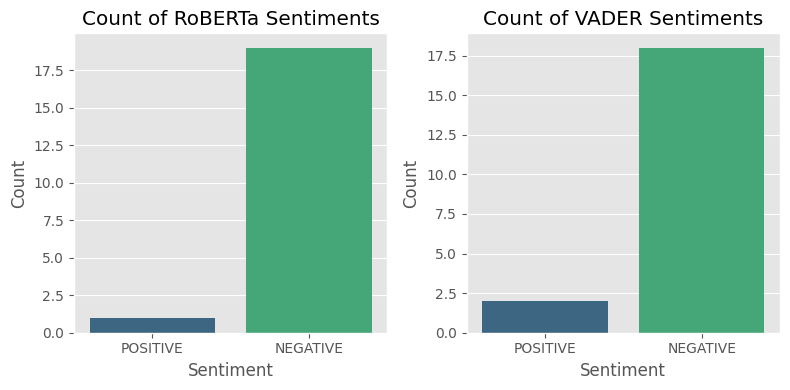

In [234]:
plt.figure(figsize=(8, 4))

# Plot Sentiment Distribution for RoBERTa (subplot 1)
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sentiment2', order=["POSITIVE", "NEGATIVE"], palette="viridis")
plt.title("Count of RoBERTa Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Plot Sentiment Distribution for VADER (subplot 2)
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='sentiment', order=["POSITIVE", "NEGATIVE"], palette="viridis")
plt.title("Count of VADER Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Show the plots
plt.tight_layout()
plt.show()

## Methode3: BERT sentiment analysis

In [235]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

#### using a model capable of handling multilingual text and provides scores from 1 to 5

In [236]:
def setup_sentiment_analyzer():
    """Set up the sentiment analysis pipeline using a free model."""
    # Using "nlptown/bert-base-multilingual-uncased-sentiment" which supports multiple languages
    # This model gives scores from 1 to 5, where 1 is very negative and 5 is very positive
    model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
    
    try:
        sentiment_analyzer = pipeline(
            "sentiment-analysis",
            model=model_name,
            tokenizer=model_name)
        return sentiment_analyzer
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

#### map score to POSITIVE, NEGATIVE

In [237]:
def map_score_to_sentiment(score):
    """Map the 1-5 score to POSITIVE/NEGATIVE/NEUTRAL."""
    if score >= 4.5:
        return "POSITIVE"
    elif score < 4.5:
        return "NEGATIVE"

#### function to analyze sentiment using SentimentAnalyzer

In [238]:
def analyze_sentiment_batch(tweets_df, sentiment_analyzer):
    """Analyze sentiment for a batch of tweets."""
    results = []
    
    for _, row in tweets_df.iterrows():
        try:
            # The model has a max token limit, so we'll truncate long tweets
            tweet_text = row['tweet_text'][:512]  # Truncate to safe length
            
            # Get sentiment prediction
            sentiment_result = sentiment_analyzer(tweet_text)[0]
            # Convert the 1-5 score to our desired format
            score = int(sentiment_result['label'][0])  # Extract the numeric score
            sentiment = map_score_to_sentiment(score)
            
            results.append({
                'tweet_id': row['id'],
                'tweet_text': row['tweet_text'],
                'date': row['tweet_date'],
                'author': row['author'],
                'sentiment': sentiment,
                'confidence': sentiment_result['score'],
                'metrics': {
                    'retweets': row['nbr_retweets'],
                    'likes': row['nbr_likes']
                }
            })
            
        except Exception as e:
            print(f"Error analyzing tweet {row['id']}: {str(e)}")
            results.append({
                'tweet_id': row['id'],
                'tweet_text': row['tweet_text'],
                'sentiment': 'ERROR',
                'error': str(e)
            })
    
    return pd.DataFrame(results)

#### analyze our tweets

In [239]:
df_result = analyze_sentiment_batch(df, setup_sentiment_analyzer())

In [240]:
df_result

,tweet_id,tweet_text,date,author,sentiment,confidence,metrics
0,1,"Après la LNFP, c'est au la Botola Pro INWI qu...",2024-11-09 22:07:54,BotolaNews,NEGATIVE,0.242876,"{'retweets': 0, 'likes': 8}"
1,2,Official Botola Pro Inwi page will follow soon,2024-11-09 21:38:11,𝗠𝗩𝗡_𝗘𝗡 | 𝗙𝗼𝗼𝘁𝗯𝗮𝗹𝗹 𝗡𝗲𝘄𝘀,POSITIVE,0.465766,"{'retweets': 3, 'likes': 30}"
2,3,Je pense très sincèrement que l’absurdité est ...,2024-11-09 10:59:35,from 04 with love,NEGATIVE,0.574516,"{'retweets': 1, 'likes': 2}"
3,4,Botola Inwi Pro is corrupted \n@fifacom_fr,2024-11-09 21:50:20,🅜🅞🅝🅒🅔🅕,NEGATIVE,0.487633,"{'retweets': 0, 'likes': 2}"
4,5,Programme de la 5eme journée du championnat du...,2024-11-16 08:35:29,Saad M,NEGATIVE,0.294675,"{'retweets': 0, 'likes': 4}"
5,6,Tous les buts de la 10ème journée de Botola Pr...,2024-11-10 19:25:57,BotolaNews,POSITIVE,0.516519,"{'retweets': 0, 'likes': 6}"
6,7,INWI \nMAROC,2024-11-16 20:08:43,Zaque bébé influenceur,POSITIVE,0.262595,"{'retweets': 0, 'likes': 0}"
7,8,Un arbitre de la botola pro inwi,2024-11-16 22:38:53,Fc Recul,POSITIVE,0.256459,"{'retweets': 0, 'likes': 0}"
8,9,A l'aeroport a casa quand la meuf d'inwi elle ...,2024-11-13 22:42:05,am,NEGATIVE,0.257792,"{'retweets': 13, 'likes': 100}"
9,10,PUTANGINA NIYOWO INWI WENDY!!!/₱:₱8:₱:₱:,2024-11-17 08:36:29,bey ◡̈,NEGATIVE,0.429835,"{'retweets': 0, 'likes': 0}"


In [241]:
sentiment_counts = df_result['sentiment'].value_counts()
print(sentiment_counts)

sentiment
NEGATIVE    12
POSITIVE     8
Name: count, dtype: int64


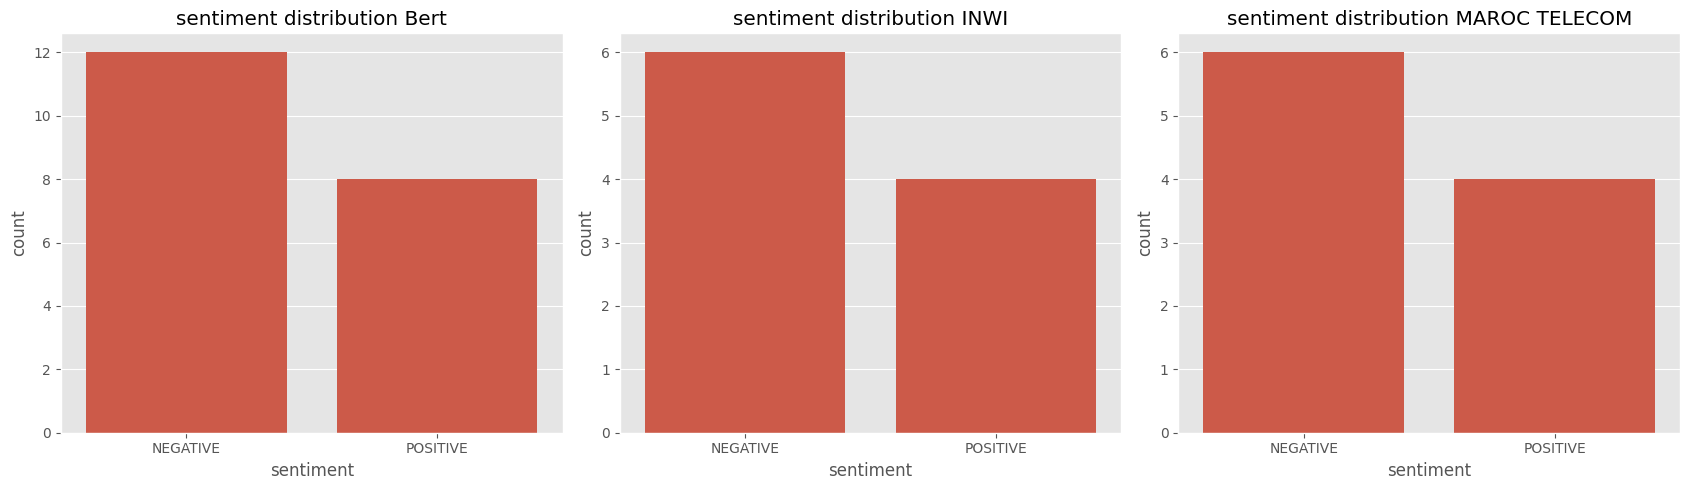

In [242]:
# sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'], alpha=0.7, edgecolor='black')
# plt.title("Sentiment Distribution Bert")
# plt.xlabel("Sentiment")
# plt.ylabel("Count")
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df_result, x='sentiment', order=['NEGATIVE', 'POSITIVE'])
plt.title('sentiment distribution Bert')

plt.subplot(1, 3, 2)
sns.countplot(data=df_result[0:10], x='sentiment', order=['NEGATIVE', 'POSITIVE'])
plt.title('sentiment distribution INWI')

plt.subplot(1, 3, 3)
sns.countplot(data=df_result[10:20], x='sentiment', order=['NEGATIVE', 'POSITIVE'])
plt.title('sentiment distribution MAROC TELECOM')

plt.tight_layout()
plt.show()

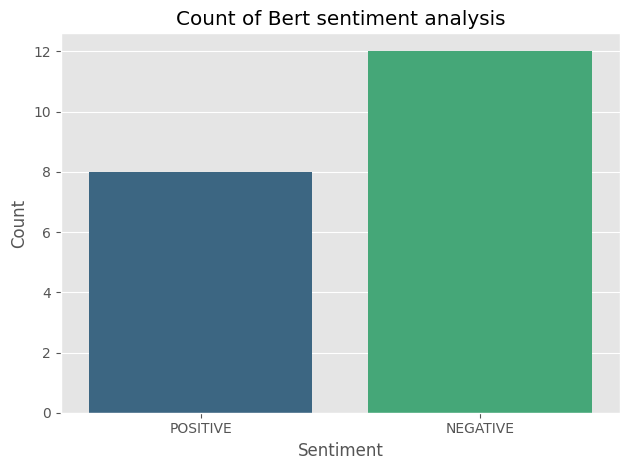

In [259]:
plt.figure()
sns.countplot(data=df_result, x='sentiment', order=["POSITIVE", "NEGATIVE"], palette="viridis")
plt.title("Count of Bert sentiment analysis")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [243]:
sentiment_counts = df_result['sentiment'][0:10].value_counts()
print(sentiment_counts)

sentiment
NEGATIVE    6
POSITIVE    4
Name: count, dtype: int64


In [257]:
# Identify negative tweets (scores <= 0.5)
negative_tweets_bert = df_result[df_result['sentiment'] == "NEGATIVE"]
print("\nNegative Tweets Analysis (Bert):")
print(f"Number of negative tweets: {len(negative_tweets_bert)}")
print("\nNegative Tweets --- Bert: ")
print(negative_tweets_bert.head())


Negative Tweets Analysis (Bert):
Number of negative tweets: 12

Negative Tweets --- Bert: 
   tweet_id                                         tweet_text  \
0         1   Après la LNFP, c'est au la Botola Pro INWI qu...   
2         3  Je pense très sincèrement que l’absurdité est ...   
3         4         Botola Inwi Pro is corrupted \n@fifacom_fr   
4         5  Programme de la 5eme journée du championnat du...   
8         9  A l'aeroport a casa quand la meuf d'inwi elle ...   

                  date             author sentiment  confidence  \
0  2024-11-09 22:07:54         BotolaNews  NEGATIVE    0.242876   
2  2024-11-09 10:59:35  from 04 with love  NEGATIVE    0.574516   
3  2024-11-09 21:50:20             🅜🅞🅝🅒🅔🅕  NEGATIVE    0.487633   
4  2024-11-16 08:35:29             Saad M  NEGATIVE    0.294675   
8  2024-11-13 22:42:05                 am  NEGATIVE    0.257792   

                          metrics  
0     {'retweets': 0, 'likes': 8}  
2     {'retweets': 1, 'likes': 2}  
